In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook
from scipy.spatial.distance import cdist
import imageio
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

plt.style.use("seaborn-dark")

import sys
sys.path.append("../")
from rl.agents.q_agent import QAgent

In [2]:
class Environment(object):
    
    def __init__(self, n_stops=8,method="angle_difference", **kwargs):
        
        print(f"Initialized Delivery Environment with {n_stops} random stops")
        print(f"Target metric for optimization is {method}")
              
        #Initializaiton 
        self.n_stops = n_stops
        self.action_space = self.n_stops
        self.observation_space = self.n_stops
        self.stops = []
        self.method = method
        
        
        #Generate Stops 
        self._generate_stops()
        self._generate_q_values()
        self.render
        self.reset()
        
        
    def _generate_stops(self):
        
        xy = np.loadtxt('test.csv', delimiter=",")
        self.x = xy[:,0]
        self.y = xy[:,1]
        
    def _generate_q_values(self):
        xy = np.column_stack([self.x,self.y])
        mat =  np.zeros((len(xy), len(xy)))
        for i in range(len(xy)):
            for j in range(len(xy)):
                if (xy[j][1]-xy[i][1]) ==0:
                    mat[i][j] = -100
                elif (xy[j][1]!=0) and (xy[i][1]!=0):
                    mat[i][j] = -100
                else: 
                    mat[i][j] = (xy[j][0]-xy[i][0])/(xy[j][1]-xy[i][1])
        self.q_stops = mat
        
    def render(self,return_img = False):
        
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)
        ax.set_title("Stops")

        # Show stops
        ax.scatter(self.x,self.y,c = "red",s = 50)

        # Show START
        if len(self.stops)>0:
            xy = self._get_xy(initial = True)
            xytext = xy[0]+0.1,xy[1]-0.05
            ax.annotate("START",xy=xy,xytext=xytext,weight = "bold")

        # Show itinerary
        if len(self.stops) > 1:
            ax.plot(self.x[self.stops],self.y[self.stops],c = "blue",linewidth=1,linestyle="--")
            
            # Annotate END
            xy = self._get_xy(initial = False)
            xytext = xy[0]+0.1,xy[1]-0.05
            ax.annotate("END",xy=xy,xytext=xytext,weight = "bold")

        plt.xticks([])
        plt.yticks([])
        
        if return_img:
            # From https://ndres.me/post/matplotlib-animated-gifs-easily/
            fig.canvas.draw_idle()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close()
            return image
        else:
            plt.show()
    
    def reset(self):

        # Stops placeholder
        self.stops = [7]

        # Random first stop
        return self.stops[-1]

    def step(self,destination):

        # Get current state
        state = self._get_state()
        new_state = destination

        # Get reward for such a move
        reward = self._get_reward(state,new_state)

        # Append new_state to stops
        self.stops.append(destination)
        done = len(self.stops) == self.n_stops

        return new_state,reward,done

    def _get_state(self):
        return self.stops[-1]


    def _get_xy(self,initial = False):
        state = self.stops[0] if initial else self._get_state()
        x = self.x[state]
        y = self.y[state]
        return x,y


    def _get_reward(self,state,new_state):
        base_reward = self.q_stops[state,new_state]
        return base_reward

def run_episode(env,agent,verbose = 1):

    s = env.reset()
    agent.reset_memory()

    max_step = env.n_stops
    
    episode_reward = 0
    
    i = 0
    while i < max_step:

        # Remember the states
        agent.remember_state(s)

        # Choose an action
        a = agent.act(s)
        
        # Take the action, and get the reward from environment
        s_next,r,done = env.step(a)

        # Tweak the reward
        r = r
        
        if verbose: print(s_next,r,done)
        
        # Update our knowledge in the Q-table
        agent.train(s,a,r,s_next)
        
        # Update the caches
        episode_reward += r
        s = s_next
        
        # If the episode is terminated
        i += 1
        if done:
            break
            
    return env,agent,episode_reward



class DeliveryQAgent(QAgent):

    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.reset_memory()

    def act(self,s):

        # Get Q Vector
        q = np.copy(self.Q[s,:])

        # Avoid already visited states
        q[self.states_memory] = -np.inf

        if np.random.rand() > self.epsilon:
            a = np.argmax(q)
        else:
            a = np.random.choice([x for x in range(self.actions_size) if x not in self.states_memory])

        return a


    def remember_state(self,s):
        self.states_memory.append(s)

    def reset_memory(self):
        self.states_memory = []



def run_n_episodes(env,agent,name="training.gif",n_episodes=1000,render_each=10,fps=10):

    # Store the rewards
    rewards = []
    imgs = []
    imgs2 = []

    # Experience replay
    for i in tqdm_notebook(range(n_episodes)):

        # Run the episode
        env,agent,episode_reward = run_episode(env,agent,verbose = 0)
        rewards.append(episode_reward)
            
        if i % render_each == 0:
            img = env.render(return_img = True)
            imgs.append(img)

    
    
    
    # Show rewards
    plt.figure(figsize = (15,3))
    plt.title("Rewards over training")
    plt.plot(rewards)
    plt.show()

    # Save imgs as gif
    imageio.mimsave(name,imgs,fps = fps)

    return env,agent

In [3]:
env = Environment()
print(env.q_stops)

Initialized Delivery Environment with 8 random stops
Target metric for optimization is angle_difference
[[-100.           -0.16217942 -100.            0.35010987 -100.
     1.84342456 -100.            1.        ]
 [  -0.16217942 -100.            0.16217942 -100.           -1.18397078
  -100.           -2.84082079 -100.        ]
 [-100.            0.16217942 -100.            0.74029957 -100.
     2.42551009 -100.            1.47370271]
 [   0.35010987 -100.            0.74029957 -100.           -0.74029957
  -100.           -2.25644377 -100.        ]
 [-100.           -1.18397078 -100.           -0.74029957 -100.
     0.55299456 -100.           -0.17745833]
 [   1.84342456 -100.            2.42551009 -100.            0.55299456
  -100.           -0.55299456 -100.        ]
 [-100.           -2.84082079 -100.           -2.25644377 -100.
    -0.55299456 -100.           -1.51510316]
 [   1.         -100.            1.47370271 -100.           -0.17745833
  -100.           -1.51510316 -100.  

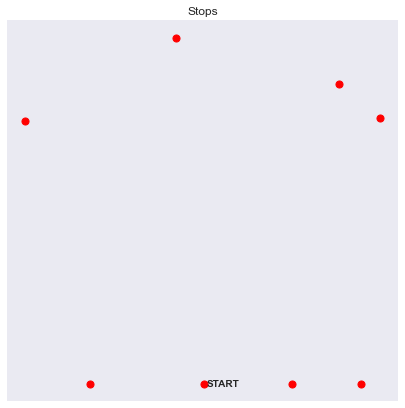

In [4]:
env.render()

In [5]:
env.stops

[7]

In [6]:
for i in [7,2]:
    env.step(i)

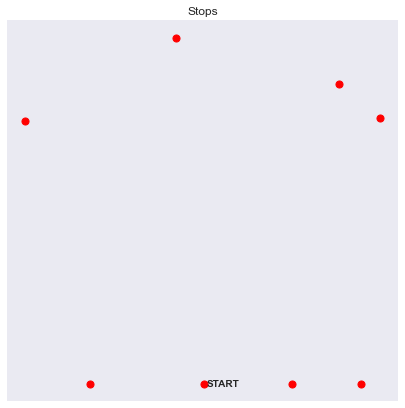

In [7]:
env.reset()
env.render()

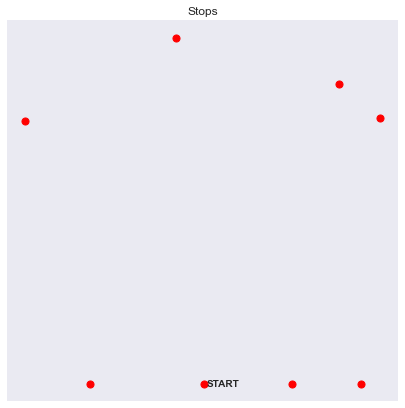

In [8]:
env.render()

In [9]:
env = Environment(n_stops = 8,method = "angle_difference" )

Initialized Delivery Environment with 8 random stops
Target metric for optimization is angle_difference


In [10]:
agent = DeliveryQAgent(env.observation_space,env.action_space)

C:\Users\PC\AppData\Local\Temp/ipykernel_3256/2086886180.py:197: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n_episodes)):


  0%|          | 0/1000 [00:00<?, ?it/s]

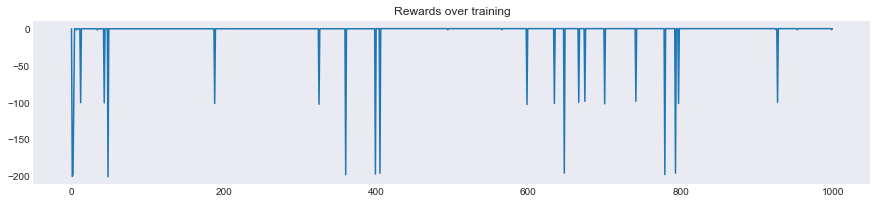

(<__main__.Environment at 0x1cbab787940>,
 <__main__.DeliveryQAgent at 0x1cba9fb3760>)

In [11]:
run_n_episodes(env,agent,"training_8_pts.gif")

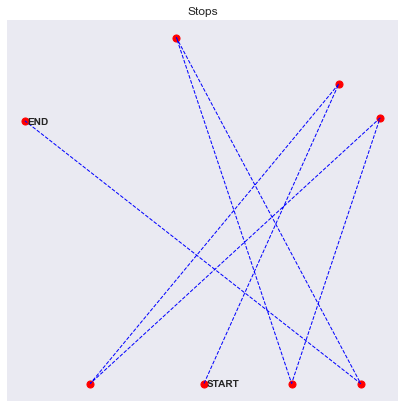

In [12]:
env.render()